In [73]:
import requests
import json
import networkx as nx
import matplotlib.pyplot as plt
import re
from openai import OpenAI
from rapidfuzz import process, fuzz
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sentence_transformers import SentenceTransformer

As a first step in the analysis, a selective extraction of relevant information was performed from the original dataset, with the aim of isolating data useful for identifying the potential culprit. Specifically, the focus was placed on the interrogations, as they represent the primary source of subjective statements made by the guests involved. The resulting dataset consists of 59 interrogations, each conducted with a different guest, at different times, and containing a unique statement.

In [74]:
url = "https://reliableai.github.io/Sherlock/june6_exam/murder_mystery.json"
response = requests.get(url)
data = response.json()

interrogations = data.get("interrogations", [])

A directed graph was constructed where each node represents a guest, and an edge from one guest to another indicates that the former mentioned the latter during their interrogation. Mentions were identified using regular expressions targeting formal titles followed by names (e.g., Sir X, Madame Y).

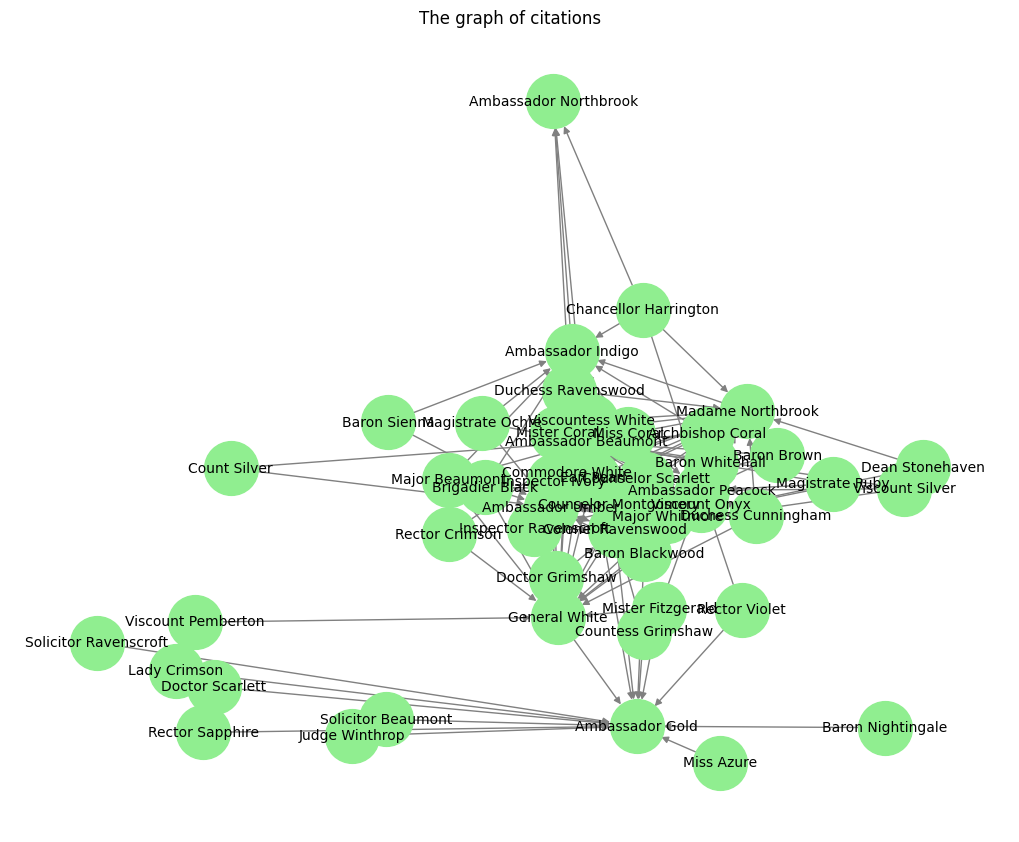

In [75]:
# graph 'guest → person cited'
G = nx.DiGraph()

for entry in interrogations:
    guest = entry["guest"]
    statement = entry["statement"]

    mentions = re.findall(r"Ambassador [A-Z][a-z]+|General [A-Z][a-z]+|Admiral [A-Z][a-z]+|Colonel [A-Z][a-z]+|Madame [A-Z][a-z]+|Sir [A-Z][a-z]+", statement)

    for mentioned in mentions:
        if mentioned != guest:
            G.add_edge(guest, mentioned)

#plot the graph of citations
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color="lightgreen", edge_color="gray", node_size=1500, font_size=10, arrows=True)
plt.title("The graph of citations")
plt.show()

This code creates a new directed graph (G_reciprocal) that includes only mutual citations between people — that is, an edge from person A to person B is kept only if B also mentions A. It then visualizes this subgraph, showing only the reciprocal relationships, with labeled nodes and arrows.
The underlying assumption is that if two people mention each other, they are likely corroborating each other's presence, which suggests they are less likely to be guilty.

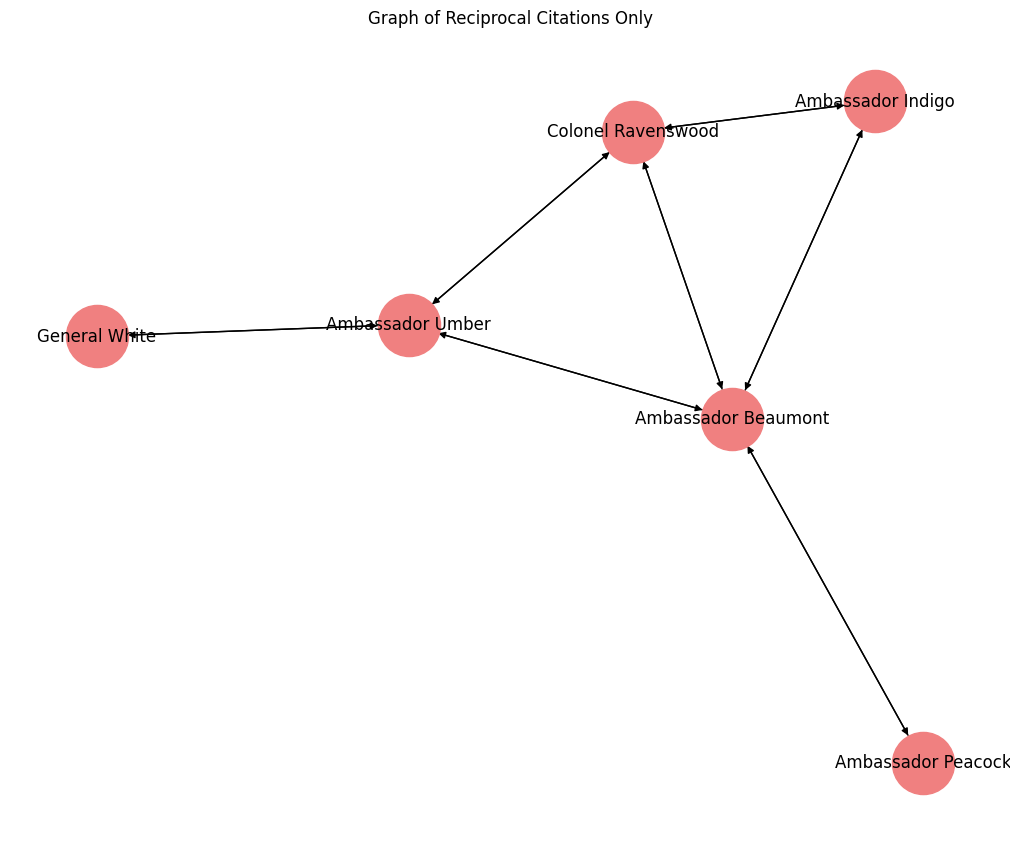

In [76]:
G_reciprocal = nx.DiGraph()

for u, v in G.edges():
    if G.has_edge(v, u):
        G_reciprocal.add_edge(u, v)

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_reciprocal, seed=42)
nx.draw(G_reciprocal, pos, with_labels=True, node_color="lightcoral", node_size=2000, arrows=True)
plt.title("Graph of Reciprocal Citations Only")
plt.show()

As we can see from the reciprocal citation graph, the previous approach is flawed because people refer to each other using variations or altered forms of their names. This inconsistency causes reciprocal connections to be missed when matching names exactly.

By analyzing the data, I noticed that some individuals are mentioned using variations or misspellings of their names. To handle this, I created a prompt that extracts people in the JSON format with fields like guest (the interrogated person) and mentioned (the people they name), ensuring accurate identification without duplicates caused by name inconsistencies.

In [77]:
prompt = f"""
You are an information extraction assistant.

You will receive:
1. A list of guest names (see below).
2. A list of testimonies. Each testimony has a guest and their statement.

Your task:
For each guest, extract a list of other guests they mention in their statement.
- Only include names that match or are close variants of other guest names (e.g. "Judge Winthrop" vs "Winthrop").
- Return the result as a valid JSON object, formatted like:
  {{
    "Guest Name A": ["Mentioned Guest 1", "Mentioned Guest 2", ...],
    ...
  }}

Be careful to handle cases where titles (like Mister, Lady, Doctor) are present.

{interrogations}
"""

client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key="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"
)


completion = client.chat.completions.create(
  model="openai/gpt-4.1",
  messages=[
{"role": "system", "content": "You are a precise information extraction assistant. Extract only what is explicitly stated."},
{"role": "user", "content": prompt}
]
)
print(completion.choices[0].message.content)

{
  "Professor Blackstone": [
    "Baron Nightingale",
    "Pemberton",
    "Duchess Summerville",
    "Lady Crimson",
    "Grimshaw",
    "Solicitor Beaumont",
    "Mister Fitzgerald",
    "Sinclair",
    "Scarlett",
    "Judge Winthrop",
    "Mister Onyx",
    "Gold",
    "Miss Azure",
    "Archbishop Whitmore",
    "Brigadier Black",
    "Dean Stonehaven",
    "Silver",
    "Ravenswood",
    "Whitmore"
  ],
  "Ambassador Indigo": [
    "Magistrate Ruby",
    "Blackwood",
    "Brown",
    "Magistrate Ochre",
    "Crimson",
    "Peacock",
    "Silver",
    "Colonel Ravenswood",
    "Baron Sienna",
    "Chancellor Harrington",
    "White",
    "Ambassador Beaumont",
    "Dean Stonehaven",
    "Miss Coral",
    "Whitehall",
    "Counselor Montgomery",
    "Viscount Silver",
    "Ivory",
    "Counselor Scarlett",
    "Duchess Cunningham",
    "Coral",
    "Major Whitmore",
    "Northbrook",
    "Onyx",
    "Major Beaumont",
    "Black",
    "Ambassador Umber",
    "Pearl",
    "Inspector

Following the cleanup of the JSON generated by GPT-4.1, I applied fuzzy name matching—using a string similarity library—to align mentioned names with the official guest list from the dataset.

In [78]:
citations_raw = completion.choices[0].message.content

if citations_raw.startswith("```json"):
    citations_raw = citations_raw[len("```json"):]

if citations_raw.endswith("```"):
    citations_raw = citations_raw[:-3]

citations_raw = citations_raw.strip()


citations_dict = json.loads(citations_raw)


guest_names = [entry["guest"] for entry in interrogations]


# Function to normalize names to the closest guest
def normalize_names(citations_dict, guest_names, threshold=85):
    normalized = {}

    for speaker, mentions in citations_dict.items():
        normalized_mentions = set()

        for name in mentions:
            match, score, _ = process.extractOne(name, guest_names, scorer=fuzz.token_sort_ratio)
            if score >= threshold:
                normalized_mentions.add(match)

        normalized[speaker] = list(normalized_mentions)

    return normalized


normalized_citations = normalize_names(citations_dict, guest_names)


print(json.dumps(normalized_citations, indent=2))


{
  "Professor Blackstone": [
    "Judge Winthrop",
    "Lady Crimson",
    "Miss Azure",
    "Dean Stonehaven",
    "Archbishop Whitmore",
    "Mister Fitzgerald",
    "Mister Onyx",
    "Solicitor Beaumont",
    "Brigadier Black",
    "Duchess Summerville",
    "Baron Nightingale"
  ],
  "Ambassador Indigo": [
    "Lady Crimson",
    "Ambassador Umber",
    "Inspector Ravenscroft",
    "Mister Fitzgerald",
    "Chancellor Harrington",
    "Magistrate Ochre",
    "Duchess Summerville",
    "Doctor Grimshaw",
    "Counselor Scarlett",
    "Major Beaumont",
    "Colonel Ravenswood",
    "Dean Stonehaven",
    "Major Whitmore",
    "Ambassador Northbrook",
    "Magistrate Ruby",
    "Ambassador Beaumont",
    "Duchess Cunningham",
    "Miss Coral",
    "Viscount Silver",
    "Counselor Montgomery",
    "Mister Coral",
    "Baron Sienna"
  ],
  "Baron Brown": [
    "Ambassador Beaumont",
    "Baron Whitehall",
    "Duchess Ravenswood",
    "Ambassador Umber",
    "Viscountess White",
    

The result is a directed graph consisting of 59 nodes—each representing one of the interviewees—and edges indicating who mentioned whom during their statements.

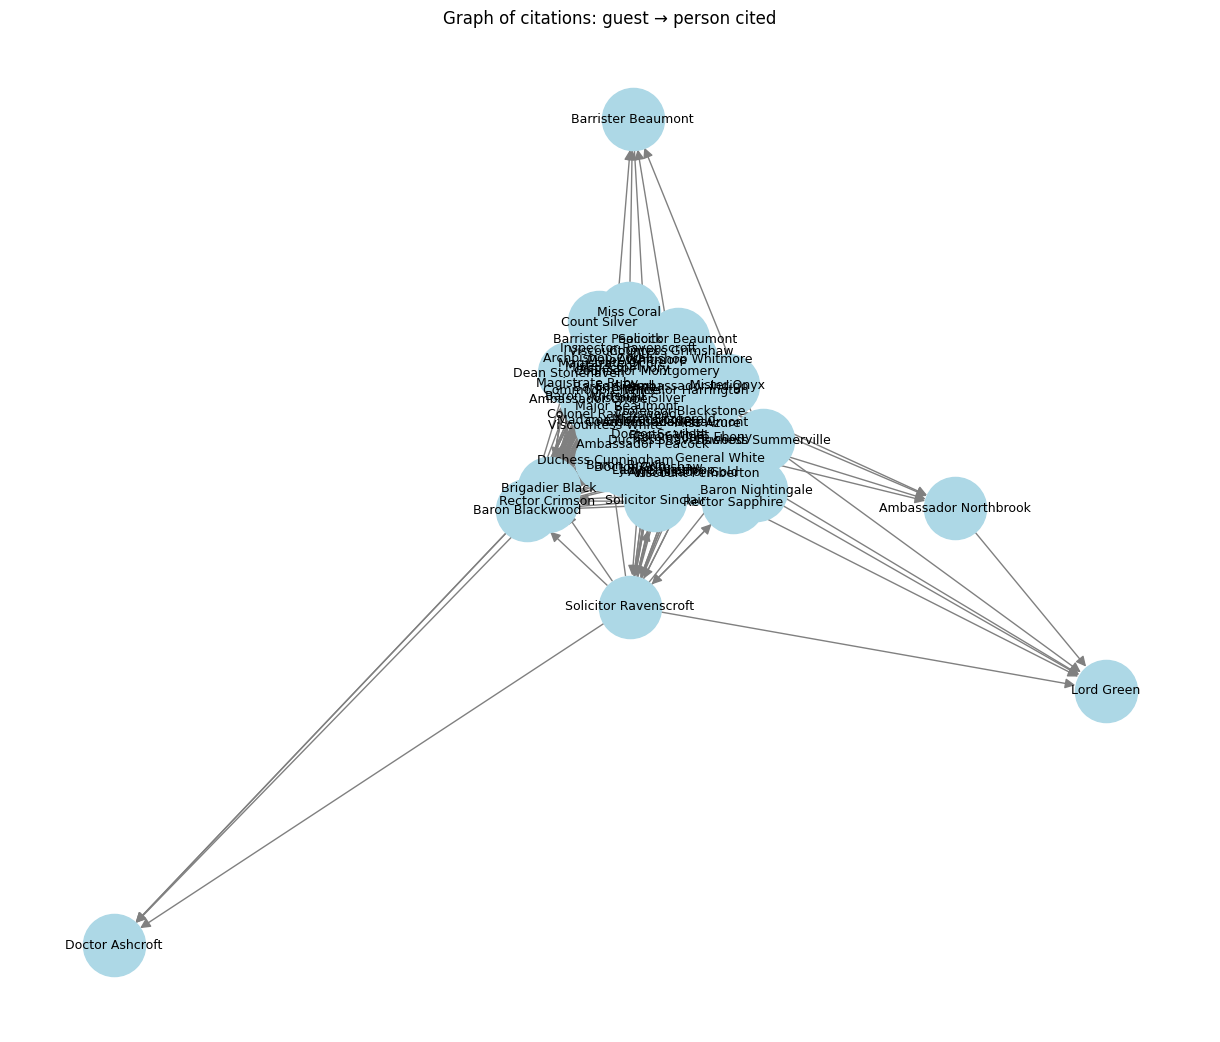

In [79]:
G = nx.DiGraph()


for guest, mentions in normalized_citations.items():
    G.add_node(guest)
    for mentioned in mentions:
        if mentioned != guest:
            G.add_edge(guest, mentioned)



plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, seed=42)

nx.draw(
    G,
    pos,
    with_labels=True,
    node_color="lightblue",
    edge_color="gray",
    node_size=2000,
    font_size=9,
    arrowsize=15,
    arrowstyle='-|>'
)

plt.title("Graph of citations: guest → person cited")
plt.show()

Following the previous approach, we proceed to remove all pairs of individuals who have mutually cited each other in their statements.

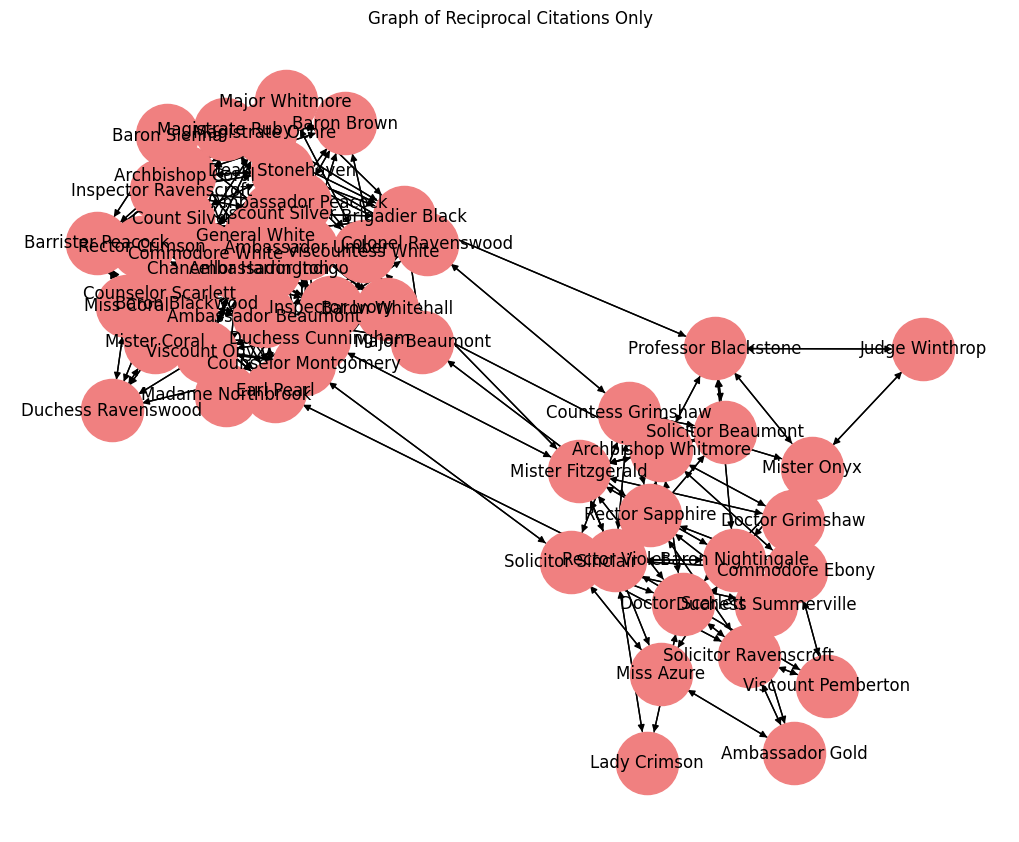

In [80]:
G_reciprocal = nx.DiGraph()

for u, v in G.edges():
    if G.has_edge(v, u):
        G_reciprocal.add_edge(u, v)

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_reciprocal, seed=42)
nx.draw(G_reciprocal, pos, with_labels=True, node_color="lightcoral", node_size=2000, arrows=True)
plt.title("Graph of Reciprocal Citations Only")
plt.show()

We thus focus on a graph where reciprocal citations have been excluded.

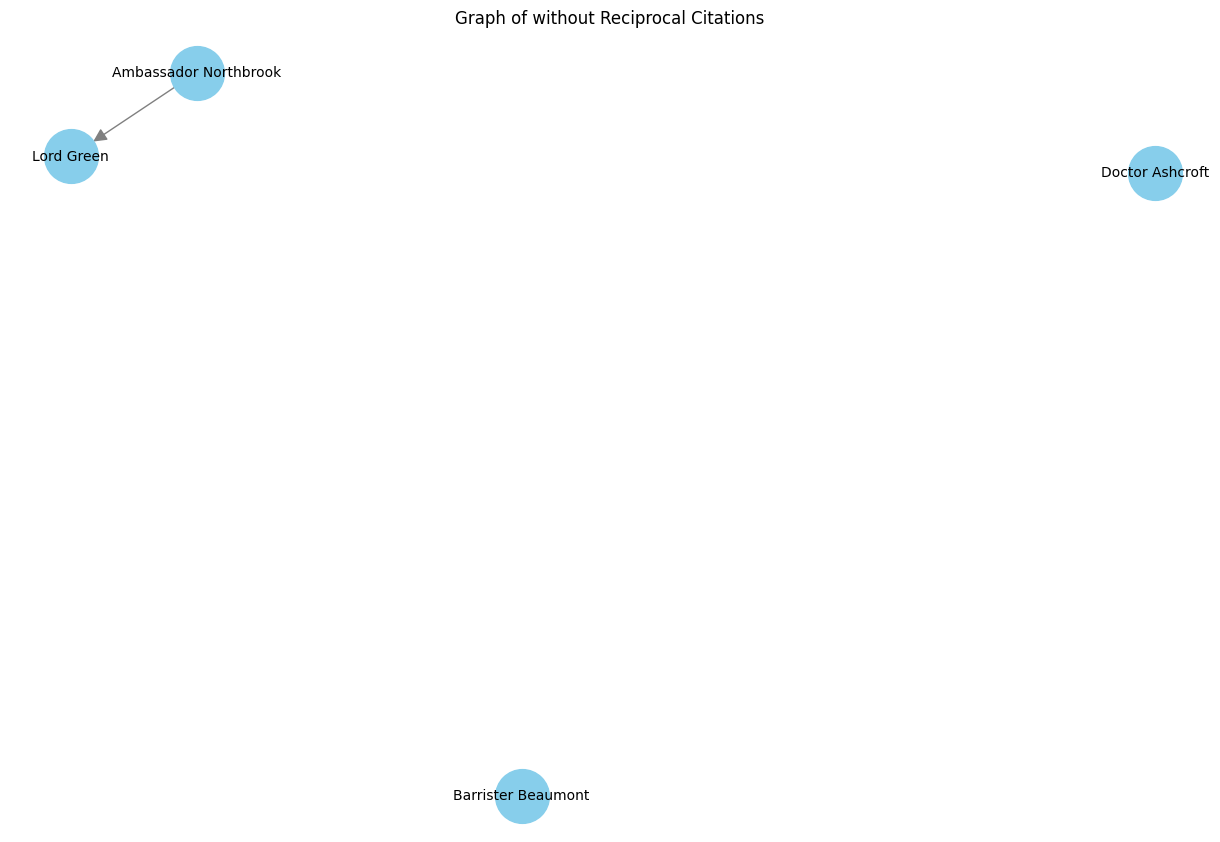

In [90]:
nodes_to_remove = set()

for u, v in G.edges():
    if G.has_edge(v, u):
        nodes_to_remove.add(u)
        nodes_to_remove.add(v)

G_filtered = G.copy()
G_filtered.remove_nodes_from(nodes_to_remove)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_filtered, seed=42)
nx.draw(G_filtered, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=1500, font_size=10, arrowsize=20)
plt.title("Graph of without Reciprocal Citations")
plt.show()

We have narrowed the scope to only four interviewees. We will now proceed with a stylistic analysis of the message left by the culprit; however, for the time being, we consider all of them in case something has been overlooked.

Calcoliamo gli embeddings delle testimonianze usando SBERT

In [91]:
statements = [interrogation['statement'] for interrogation in data['interrogations']]
guests = [interrogation['guest'] for interrogation in data['interrogations']]


model = SentenceTransformer('all-MiniLM-L6-v2')

embeddings = model.encode(statements, show_progress_bar=True)

print(f"Calcolati {len(embeddings)} embeddings")


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Calcolati 59 embeddings


In [84]:
victim_note = data['metadata']['victim_note']

# Embedding victime node
victim_embedding = model.encode([victim_note])[0]

The suspects are identified by combining two factors: how different their statements are compared to others (measured by discordance in embeddings) and how connected they are within the citation network (measured by their node degree in the graph). Those with unique statements and many connections receive higher scores, making them more likely suspects.

In [87]:
sim_matrix = cosine_similarity(embeddings)

discordance = 1 - np.mean(sim_matrix, axis=1)

degree_dict = dict(G.degree())
degrees = np.array([degree_dict.get(guest, 0) for guest in guests])


degree_norm = (degrees - degrees.min()) / (degrees.max() - degrees.min() + 1e-9)
discordance_norm = (discordance - discordance.min()) / (discordance.max() - discordance.min() + 1e-9)

score = degree_norm + discordance_norm

top_indices = np.argsort(score)[::-1][:5]
print("Top 5 suspects (using the complete graph):")
for i in top_indices:
    print(f"{guests[i]} — score: {score[i]:.3f}, degree_norm: {degree_norm[i]:.3f}, discordance_norm: {discordance_norm[i]:.3f}")


Top 5 suspects (using the complete graph):
Viscount Onyx — score: 1.215, degree_norm: 0.773, discordance_norm: 0.442
Counselor Montgomery — score: 1.145, degree_norm: 0.932, discordance_norm: 0.213
Brigadier Black — score: 1.133, degree_norm: 0.886, discordance_norm: 0.246
Ambassador Beaumont — score: 1.102, degree_norm: 1.000, discordance_norm: 0.102
Inspector Ivory — score: 1.095, degree_norm: 0.705, discordance_norm: 0.391


This code compares the victim’s note embedding with all guest statement embeddings, calculating stylistic similarity scores, then ranks and displays the guests from most to least similar.

In [88]:
embeddings_to_use = embeddings

similarities = cosine_similarity([victim_embedding], embeddings_to_use)[0]

guests_to_use = guests
similarity_scores = list(zip(guests_to_use, similarities))

similarity_scores.sort(key=lambda x: x[1], reverse=True)

print("Stylistic similarity between statements and the victim’s note:")
for guest, score in similarity_scores:
    print(f"{guest}: {score:.3f}")


Stylistic similarity between statements and the victim’s note:
Doctor Ashcroft: 0.404
Viscount Pemberton: 0.396
Baron Sienna: 0.391
Lord Green: 0.361
Inspector Ivory: 0.337
Brigadier Black: 0.336
Counselor Montgomery: 0.325
Viscount Onyx: 0.309
Major Whitmore: 0.305
General White: 0.299
Ambassador Gold: 0.299
Mister Onyx: 0.298
Ambassador Umber: 0.293
Archbishop Coral: 0.290
Duchess Summerville: 0.290
Ambassador Northbrook: 0.290
Chancellor Harrington: 0.290
Earl Pearl: 0.289
Solicitor Ravenscroft: 0.286
Rector Violet: 0.286
Commodore White: 0.285
Counselor Scarlett: 0.285
Miss Azure: 0.283
Rector Sapphire: 0.281
Major Beaumont: 0.280
Rector Crimson: 0.279
Professor Blackstone: 0.279
Ambassador Peacock: 0.279
Viscount Silver: 0.279
Lady Crimson: 0.274
Solicitor Beaumont: 0.269
Mister Fitzgerald: 0.268
Duchess Cunningham: 0.268
Ambassador Indigo: 0.267
Doctor Grimshaw: 0.266
Count Silver: 0.266
Solicitor Sinclair: 0.265
Baron Blackwood: 0.260
Viscountess White: 0.258
Magistrate Ochre: 0

In [89]:
filtered_similarity_scores = [(guest, score) for guest, score in similarity_scores if guest in G_filtered.nodes()]

print("Stylistic similarity between statements and the victim’s note (filtered):")
for guest, score in filtered_similarity_scores:
    print(f"{guest}: {score:.3f}")

Stylistic similarity between statements and the victim’s note (filtered):
Doctor Ashcroft: 0.404
Lord Green: 0.361
Ambassador Northbrook: 0.290
Barrister Beaumont: 0.253


Based on the stylistic similarity analysis filtered by our graph filtered, I contend that Doctor Ashcroft is the most likely suspect to have committed the murder.